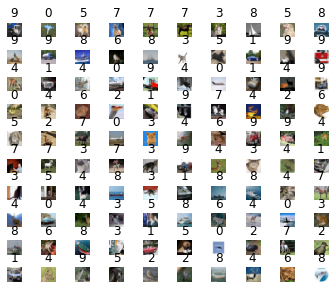

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Hidden Layers: 2
Layer 1 Neurons: 100
Layer 2 Neurons: 100
Training Images: 50000
Testing Images: 10000
Activation Function: relu
Output Activation Function: softmax
Solver: sgd
Batch Size: 10
Initial Learning Rate: 0.001
Iterations: 5
Possible Classes: [0 1 2 3 4 5 6 7 8 9]
Overall Trained Loss: 1.4908665779827917
Test Accuracy Score (%): 46.050000000000004
Image 0 Predicted Class: 3 Actual Class: 3
Image 1 Predicted Class: 1 Actual Class: 8
Image 2 Predicted Class: 8 Actual Class: 8
Image 3 Predicted Class: 8 Actual Class: 0
Image 4 Predicted Class: 4 Actual Class: 6
Image 5 Predicted Class: 6 Actual Class: 6
Image 6 Predicted Class: 3 Actual Class: 1
Image 7 Predicted Class: 6 Actual Class: 6
Image 8 Predicted Class: 5 Actual Class: 3
Image 9 Predicted Class: 1 Actual Class: 1


In [1]:

import tarfile
import numpy
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import os
import mkl

#My computer was restricting processing to only one core
#Below retrieves the number of logical CPUs aka threads and forces the program to utilize them
cpus = os.cpu_count()
mkl.set_num_threads(cpus)

#****CIFARPATH NEEDS TO BE SET
#File Needs to be unzipped to '.tar' NOT '.tar.gz' & BINARY format
curr = os.getcwd()
cifarPath = os.path.join(curr,'cifar-10-binary.tar')

#VARIABLE PARAMETERS SET HERE
neurons1 = 100
neurons2 = 100
learningRate = 0.001
maxIterations = 5000
momentum = 0.9
actFunct = 'relu'   #Options: 'relu', 'tanh', 'logistic', 'identity'
solver = 'sgd'      #Options: 'ibfgs', 'sgd', 'adam'
batchSize = 10     #Minibatch size for stochastic optimizer
numberTraining = 50000  #Range 0 - 50000
numberTesting = 10000   #Range 0 -10000

# Function for extracting cifar10 images from zip file into 5 training batches and one test batch
def cifar10_Load(path):    
    #Names of image batch files in cifar-10-python.tar
    batchNames = ['cifar-10-batches-bin/data_batch_1.bin',
             'cifar-10-batches-bin/data_batch_2.bin',
             'cifar-10-batches-bin/data_batch_3.bin',
             'cifar-10-batches-bin/data_batch_4.bin',
             'cifar-10-batches-bin/data_batch_5.bin',
             'cifar-10-batches-bin/test_batch.bin']
    
    with tarfile.open(path) as tar_object:
         batchSize = 10000 * ( 32*32*3 + 1 )                     #Total number of bytes for each bin file. Each File Contains 10,000 32x32 color images with 10,000 labels
         totalBytes = numpy.zeros(batchSize*6, dtype="uint8")    #Total number bytes for all files. 5 Training & 1 Test files
         members = []
         for file in batchNames:
             members.append(tar_object.getmember(file))          #Gets members from tar file and ensures sorted from batch 1 to 5              

         for i, member in enumerate(members):                    #Retrieves byte data from all batch files
            f = tar_object.extractfile(member)
            totalBytes[i * batchSize:(i + 1) * batchSize] = numpy.frombuffer(f.read(), 'B')
    
    labels = totalBytes[::3073]
    images = numpy.delete(totalBytes, numpy.arange(0, totalBytes.size, 3073)).reshape(-1, 3072).astype('float32')/255 #Delete labels from totalbytes using array of label index locations then convert into 60,000 image x 3072 byte array (byte values in decimal value i.e. 255 = 0xFF)
    
    trainImages = images[0:50000,:]
    trainLabels = labels[0:50000]
    testImages = images[50000:60000,:]
    testLabels = labels[50000:60000]    
    return trainImages, trainLabels, testImages, testLabels

def random_IndexGen(numIndices):
    indices = numpy.random.randint(0,50000, numIndices)
    return indices

def image_Gen(imgArray, imgLabel, indices):
    #img1 = imgArray[110,:]
    imageHolder = numpy.zeros((32,32,3,len(indices))) 
    labelHolder = numpy.zeros(len(indices))
    for pic in range(0, len(indices)):
        img = imgArray[indices[pic],:]
        labelHolder[pic] = imgLabel[indices[pic]]
        for hue in range(0,3):
            for row in range(0,32):
                for col in range(0,32):
                    imageHolder[row,col,hue,pic] = img[1024*hue + 32*row + col]
    return imageHolder, labelHolder

def image_Display(images, labels):            #This assumes a 4 dimensional array with the 4 dimension representing image index
    numImages = images.shape[3]
    numCol = 10                               #Could be improved here to make number of Col/Rows dynamic and dependent on input data
    numRow = int(images.shape[3]/numCol)
    f, ax = plt.subplots(numRow,numCol)
    for row in range(0, numRow):
        for col in range(0, numCol):
            ax[row, col].imshow(images[:,:,:,10*row+col])
            ax[row, col].title.set_text(int(labels[10*row+col]))
            ax[row, col].axis('off')
    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.2, hspace=0.9)
    plt.show()        
            
#Load data from cifar10
trainImg, trainLbl, testImg, testLbl = cifar10_Load(cifarPath) #Matrix Dimensions = [50000x3072], [50000x1], [10000x3072], [10000x1]
                                
#Generate 100 Random Indices
randIndices = random_IndexGen(100)

#Format Byte Data input 4Dimensional Array
pictures, picLabels = image_Gen(trainImg, trainLbl, randIndices)

#Display Images
image_Display(pictures, picLabels)

#Below Creates Neural Network, trains, gets parameters, and tests.
trainX = trainImg[0:numberTraining,:]
trainY = trainLbl[0:numberTraining]
mlp = MLPClassifier(hidden_layer_sizes = (neurons1,neurons2), activation = actFunct, solver = solver, batch_size = batchSize, learning_rate = 'adaptive', learning_rate_init = learningRate, max_iter = maxIterations, shuffle = True, momentum = momentum, nesterovs_momentum = False, verbose = False)
mlp.fit(trainX,trainY)
iterations = mlp.n_iter_
#lay1Bias = mlp.intercepts_[0]
#lay1Weights = mlp.coefs_[0]
classes = mlp.classes_
layers = mlp.n_layers_ - 2 #Counts input and output as layer
#outputs = mlp.n_outputs_
activationFunct = mlp.out_activation_
trainedLoss = mlp.loss_

#Test Trained FC 2 Layer NN
testX = testImg[0:numberTesting,:]
testY = testLbl[0:numberTesting]
pred = mlp.predict(testX)
#probPred = mlp.predict_proba(testX)
percentAccurate = mlp.score(testX, testY)*100.0

print(f'Hidden Layers: {layers}')
print(f'Layer 1 Neurons: {neurons1}')
print(f'Layer 2 Neurons: {neurons2}')
print(f'Training Images: {numberTraining}')
print(f'Testing Images: {numberTesting}')
print(f'Activation Function: {actFunct}')
print(f'Output Activation Function: {activationFunct}')
print(f'Solver: {solver}')
print(f'Batch Size: {batchSize}')
print(f'Initial Learning Rate: {learningRate}')
print(f'Iterations: {iterations}')
print(f'Possible Classes: {classes}')
print(f'Overall Trained Loss: {trainedLoss}')
print(f'Test Accuracy Score (%): {percentAccurate}')

#Print 10 image classifications and their predictions from training set
for image in range(0, 10):
    print(f'Image {image} Predicted Class: {pred[image]} Actual Class: {testY[image]}')
    